In [1]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import norm
from math import sqrt
import EpiClockNBL.src.util as pc_util
pc_consts = pc_util.consts
import EpiClockNBL.Select_fCpGs.util as local_util
import EpiClockNBL.src.maxima as maxima

In [2]:
proj_dir = os.path.join(pc_consts['official_indir'], 'TARGET')
c_beta_dir = os.path.join(pc_consts['repo_dir'], 'Select_fCpGs', 'outputs')

In [3]:
figure_outdir = 'figures'
os.makedirs(figure_outdir, exist_ok=True)


covar_path_outdir = os.path.join(figure_outdir, 'covar_path')
os.makedirs(covar_path_outdir, exist_ok=True)

In [4]:
clinical = {}

In [5]:
c_beta = pd.read_table(os.path.join(c_beta_dir, 'NBL.c_beta.txt'), index_col=0, header=None).squeeze('columns')
LUMP_purity = pd.read_table(os.path.join(proj_dir, 'LUMP_purity.txt'), index_col=0, header=None).squeeze('columns')

In [7]:
GMM_results_TARGET = pd.read_csv(os.path.join(pc_consts['repo_dir'], 'Gaussian Mixture Model', 'TARGET_tumor_params_GMM_summary.csv'), index_col=0)
GMM_results_TARGET.index = GMM_results_TARGET.index.map(lambda x:x.replace('.', '-'))

GMM_results_Henrich = pd.read_csv(os.path.join(pc_consts['repo_dir'], 'Gaussian Mixture Model', 'Heinrich_tumor_params_GMM_summary.csv'), index_col=0)

In [8]:
# Import TARGET clinical table
clinical['TARGET'] = pd.read_table(
    os.path.join(proj_dir, 'cohort1.clinical.tsv')
)
clinical['TARGET'] = clinical['TARGET'].set_index('submitter_id')

sampleIDs = c_beta.index.values
patient_to_sample_IDs = pd.Series(data=sampleIDs, index=[pc_util.sampleToPatientID(x) for x in sampleIDs]).rename('sampleID')
clinical['TARGET'] = clinical['TARGET'].merge(patient_to_sample_IDs, left_index=True, right_index=True, how='left')

clinical['TARGET'] = clinical['TARGET'].merge(c_beta.rename('c_beta'), left_on='sampleID', right_index=True)
# clinical['TARGET'] = clinical['TARGET'].merge(c_beta_traditional.rename('c_beta_traditional'), left_on='sampleID', right_index=True)

clinical['TARGET'] = clinical['TARGET'].merge(LUMP_purity.rename('LUMP'), left_on='sampleID', right_index=True)

# Process certain columns
clinical['TARGET']['Age'] = clinical['TARGET']['age_at_diagnosis'] / 365
        
assert not clinical['TARGET']['Age'].astype(float).isna().any()
clinical['TARGET']['Age >= 1.5'] = (clinical['TARGET']['Age'] >= 1.5).map(lambda x:'Age >= 1.5 years' if x else 'Age < 1.5 years')
# clinical['TARGET']['Age >= 1.5'] = clinical['TARGET']['Age'].map(ageStratify)

# Add GMM phi
clinical['TARGET'] = clinical['TARGET'].merge(GMM_results_TARGET['phi_mean'].rename('phi'), left_on='sampleID', right_index=True)

clinical['TARGET'].to_csv(os.path.join(proj_dir, 'clinical.annotated.tsv'), sep='\t')

In [21]:
# Import Henrich clinical table
clinical['Henrich'] = pd.read_table(
    os.path.join(pc_consts['official_indir'], 'Henrich', 'sample_annotations_clean.txt'), index_col='Sample_geo_accession'
)

clinical['Henrich']['inss stage'] = 'Stage ' + clinical['Henrich']['inss stage'].astype(str)
clinical['Henrich']['inss stage'] = clinical['Henrich']['inss stage'].map(lambda x:'Stage 2' if x in['Stage 2.1', 'Stage 2.2'] else x)
clinical['Henrich']['age at diagnosis'] = clinical['Henrich']['age at diagnosis'].map({'>=1.5 years':'Age >= 1.5 years', '<1.5 years':'Age < 1.5 years'})

# Add GMM phi
clinical['Henrich'] = clinical['Henrich'].merge(GMM_results_Henrich['phi_mean'].rename('phi'), left_index=True, right_index=True)

In [12]:
pc_util.getCorrelation(clinical['TARGET'], 'phi', 'LUMP')

LinregressResult(slope=-0.4891897291839833, intercept=0.8486504092408691, rvalue=-0.274362118662765, pvalue=4.9329655454698975e-05, stderr=0.11803705206865005, intercept_stderr=0.0932162425590263)

## Make Figures

In [29]:
## Configure graph
sf = pc_consts['sf']
figsize = np.array([7, 4])
sns.set(rc={"savefig.bbox":'tight', 'axes.linewidth':sf}, font_scale=1, style='ticks')

In [30]:
# ## Must set dataframe names for use of saveBoxPlotNew and saveCorrelationPlot

clinical['TARGET'].name = 'Discovery'
clinical['Henrich'].name = 'Validation'

### 3 example tumors

/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/m9/kv2y3r0s0p1_cl3s3py1wprh0000gn/T/ipykernel_67295/1220319549.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_vals = norm.pdf(x_vals, mu_list[j], sd_list[j]) * weight_list[j]
/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/m9/kv2y3r0s0p1_cl3s3py1wprh0000gn

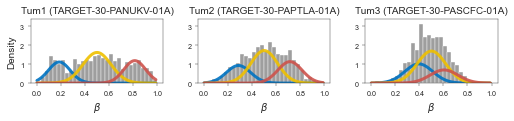

In [49]:
## Plot beta value distriubtions for 3 example tumors

beta_values_Clock = pd.read_table(
    os.path.join(pc_consts['official_indir'], 'TARGET', 'NBL.methyl.antiNonIterClustNotStuck_sites.tsv'),
    index_col=0)

sample_list = {
    'Tum1':'TARGET-30-PANUKV-01A',
    'Tum2':'TARGET-30-PAPTLA-01A',
    'Tum3':'TARGET-30-PASCFC-01A'
}

# Create plot axes
fig, axes = plt.subplots(1, len(sample_list), figsize=np.array(figsize) * [2.5, 0.8] * sf)
fig.tight_layout(pad=0.2)

# Color of each distribution in order (left -> right)
chosen_tumor_colors = [pc_consts['palette_jco'][i] for i in [0, 1, 3]]

# X coordinates for curves
x_vals = np.linspace(0, 0.99, 100)

for i, tum_id in enumerate(sample_list):
    ax = axes[i]
    samp = sample_list[tum_id]
    patient = pc_util.sampleToPatientID(samp)
    
    # Plot distribution
    sns.histplot(ax=ax, x=beta_values_Clock[samp], stat='density',
                 color=pc_consts['palette_jco'][2],
                 bins=30, alpha=pc_consts['opacity'],
                binrange=(0, 1))
    
    # Customize plot
    ax.set_title(f'{tum_id} ({samp})', fontsize=pc_consts['labelfontsize'] * sf)
    ax.set_xlabel(r'$\beta$', fontsize=pc_consts['labelfontsize'] * sf)
    if i == 0: # Only have y-axis label on left-most plot
        ax.set_ylabel('Density', fontsize=pc_consts['labelfontsize'] * sf)
    else:
        ax.set_ylabel('')
    ax.tick_params(axis='both', labelsize=pc_consts['ticksfontsize'] * sf, width=sf, length=8 * sf)

    # Weight of each of three distributions
    weight_list = GMM_results_TARGET.loc[samp, ['psi_1_mean', 'psi_2_mean', 'psi_3_mean']]
    
    # Holds the max y-axis limit max
    y_max = float('-Inf')
    
    X_mean = GMM_results_TARGET.loc[samp, 'X_mean']
    N_mean = GMM_results_TARGET.loc[samp, 'N_mean']
    mu_list = [X_mean, 0.5, 1 - X_mean]
    sd_list = [sqrt(mu * (1 - mu) / N_mean) for mu in mu_list]
    
    # Plot each distribution
    for j in range(weight_list.shape[0]):

        # X and Y coords for curve
        y_vals = norm.pdf(x_vals, mu_list[j], sd_list[j]) * weight_list[j]
        
        # Plot curve
        ax.plot(x_vals, y_vals, lw=3, alpha=0.9,
                color=chosen_tumor_colors[j]
               )
        
        # Update max
        y_max = max(y_max, ax.get_ylim()[1])
    
#     y_vals_kernel = np.stack([norm.pdf(x_vals, mu_list[j], sd_list[j]) * weight_list[j] for j in range(weight_list.shape[0])], axis=0).sum(axis=0)
#     ax.plot(x_vals, y_vals_kernel, lw=1, alpha=0.9, color='gray')
    
# Align y-axis limits
for i in range(len(sample_list)):
    ax = axes[i]
    ax.set_ylim(0, y_max * 1.03)

# Save figure
fig.savefig(os.path.join(figure_outdir, 'example_peak_decomp.pdf'), format='pdf', pad_inches=0.1)

# Tumor mitotic age distribution

/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


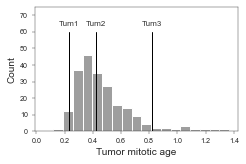

In [355]:
plot_data = clinical['TARGET'].loc[clinical['TARGET']['in_analysis_dataset'], 'phi']

# Create plot
fig, ax = plt.subplots(figsize=figsize * [1.3, 0.95] * sf)
sns.histplot(ax=ax, x=plot_data,
             color=pc_consts['palette_jco'][2], alpha=pc_consts['opacity'])

# Mark (with vertical lines) the c_beta values of three
#   example tumors from plot in the previous cell
line_color = 'black'
tumor_heights = [0.8, 0.8, 0.8]

x_0 = clinical['TARGET'].loc[pc_util.sampleToPatientID(sample_list['Tum1']), 'phi']
x_1 = clinical['TARGET'].loc[pc_util.sampleToPatientID(sample_list['Tum2']), 'phi']
x_2 = clinical['TARGET'].loc[pc_util.sampleToPatientID(sample_list['Tum3']), 'phi']

ax.axvline(x=x_0, ymax=tumor_heights[0], lw=2.5 * sf, color=line_color)
ax.axvline(x=x_1, ymax=tumor_heights[1], lw=2.5 * sf, color=line_color)
ax.axvline(x=x_2, ymax=tumor_heights[2], lw=2.5 * sf, color=line_color)

# Customize figure
ax.set_xlabel('Tumor mitotic age', fontsize=pc_consts['labelfontsize']*sf)
ax.set_ylabel('Count', fontsize=pc_consts['labelfontsize'] * sf)
ax.tick_params(axis='both', labelsize=pc_consts['ticksfontsize'] * sf, width=sf, length=8 * sf)
ax.set_ylim(top=75)

# Widen plot a little
xlim = ax.get_xlim()
width = xlim[1] - xlim[0]
ax.set_xlim(left = xlim[0] - width/20)

# Annotate the vertical lines with text for all 3 tumors
y_height = ax.get_ylim()[1]

ax.text(x_0, (tumor_heights[0]+0.05)*y_height,
        'Tum1', color=line_color,
        ha="center", fontfamily='sans-serif', fontsize=0.8 * pc_consts['labelfontsize'] * sf, alpha=pc_consts['opacity']
       )
ax.text(x_1, (tumor_heights[1]+0.05)*y_height,
        'Tum2', color=line_color,
        ha="center", fontfamily='sans-serif', fontsize=0.8 * pc_consts['labelfontsize'] * sf, alpha=pc_consts['opacity']
       )
ax.text(x_2-0.005, (tumor_heights[2]+0.05)*y_height,
        'Tum3', color=line_color,
        ha="center", fontfamily='sans-serif', fontsize=0.8 * pc_consts['labelfontsize'] * sf, alpha=pc_consts['opacity']
       )

# Save figure
fig.savefig(os.path.join(figure_outdir, 'mitotic_age_distribution.pdf'), format='pdf', pad_inches=0.1)

# Covariate Analysis

<Axes: title={'center': 'Validation'}, ylabel='Tumor mitotic age'>

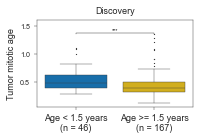

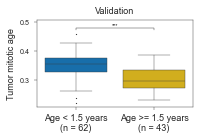

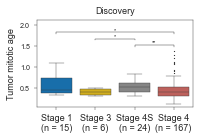

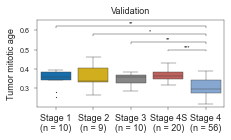

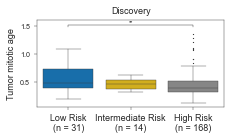

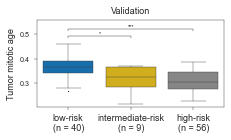

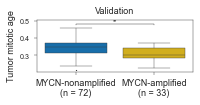

In [40]:
pc_util.saveBoxPlotNew(clinical['TARGET'], 'Age >= 1.5', restrict=True,
                   var_y='phi', outfile=True, title=True, signif_bar_heights = 0.02,
                   palette=pc_consts['palette_jco'], xlabel='', ylabel='Tumor mitotic age',
                       outdir=covar_path_outdir,
                   figsize=figsize, labelfontsize=pc_consts['labelfontsize'] * 0.9, ticksfontsize=pc_consts['ticksfontsize'], sf=sf, linewidth=pc_consts['linewidth'], fliersize=pc_consts['fliersize'])

pc_util.saveBoxPlotNew(clinical['Henrich'], 'age at diagnosis', restrict=False,
                   var_y='phi', outfile=True, title=True, signif_bar_heights = 0.02,
                   palette=pc_consts['palette_jco'], xlabel='', ylabel='Tumor mitotic age',
                       outdir=covar_path_outdir,
                   figsize=figsize, labelfontsize=pc_consts['labelfontsize'] * 0.9, ticksfontsize=pc_consts['ticksfontsize'], sf=sf, linewidth=pc_consts['linewidth'], fliersize=pc_consts['fliersize'])

pc_util.saveBoxPlotNew(clinical['TARGET'], 'inss_stage', restrict=True,
                   var_y='phi', outfile=True, title=True, signif_bar_heights = 0.15,
                   palette=pc_consts['palette_jco'], xlabel='', ylabel='Tumor mitotic age',
                       outdir=covar_path_outdir, use_groups=['Stage 1', 'Stage 3', 'Stage 4S', 'Stage 4'],
                   figsize=figsize, labelfontsize=pc_consts['labelfontsize'] * 0.9, ticksfontsize=pc_consts['ticksfontsize'], sf=sf, linewidth=pc_consts['linewidth'], fliersize=pc_consts['fliersize'])

pc_util.saveBoxPlotNew(clinical['Henrich'], 'inss stage', restrict=False,
                   var_y='phi', outfile=True, title=True, signif_bar_heights = 0.04,
                   palette=pc_consts['palette_jco'], xlabel='', ylabel='Tumor mitotic age',
                       outdir=covar_path_outdir, use_groups=['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4S', 'Stage 4'],
                   figsize=figsize * [1.2, 1], labelfontsize=pc_consts['labelfontsize'] * 0.9, ticksfontsize=pc_consts['ticksfontsize'], sf=sf, linewidth=pc_consts['linewidth'], fliersize=pc_consts['fliersize'])

pc_util.saveBoxPlotNew(clinical['TARGET'], 'cog_neuroblastoma_risk_group', restrict=True,
                   var_y='phi', outfile=True, title=True, signif_bar_heights = 0.15,
                   palette=pc_consts['palette_jco'], xlabel='', ylabel='Tumor mitotic age',
                       outdir=covar_path_outdir, use_groups=["Low Risk", "Intermediate Risk", "High Risk"],
                   figsize=figsize * [1.2, 1], labelfontsize=pc_consts['labelfontsize'] * 0.9, ticksfontsize=pc_consts['ticksfontsize'], sf=sf, linewidth=pc_consts['linewidth'], fliersize=pc_consts['fliersize'])

pc_util.saveBoxPlotNew(clinical['Henrich'], 'current risk category', restrict=False,
                   var_y='phi', outfile=True, title=True, signif_bar_heights = 0.03,
                   palette=pc_consts['palette_jco'], xlabel='', ylabel='Tumor mitotic age',
                       outdir=covar_path_outdir, use_groups=['low-risk', 'intermediate-risk', 'high-risk'],
                   figsize=figsize * [1.2, 1], labelfontsize=pc_consts['labelfontsize'] * 0.9, ticksfontsize=pc_consts['ticksfontsize'], sf=sf, linewidth=pc_consts['linewidth'], fliersize=pc_consts['fliersize'])

pc_util.saveBoxPlotNew(clinical['Henrich'], 'mycn status', restrict=False,
                   var_y='phi', outfile=True, title=True, signif_bar_heights = 0.023,
                   palette=pc_consts['palette_jco'], xlabel='', ylabel='Tumor mitotic age',
                       outdir=covar_path_outdir, use_groups=['MYCN-nonamplified', 'MYCN-amplified'],
                   figsize=figsize * [1, 0.6], labelfontsize=pc_consts['labelfontsize'] * 0.9, ticksfontsize=pc_consts['ticksfontsize'], sf=sf, linewidth=pc_consts['linewidth'], fliersize=pc_consts['fliersize'])


In [37]:
pc_util.getCorrelation(clinical['TARGET'], 'LUMP', 'phi')

LinregressResult(slope=-0.15387602737017095, intercept=0.8535004512497083, rvalue=-0.274362118662765, pvalue=4.9329655454698975e-05, stderr=0.03712889206629028, intercept_stderr=0.01882731399479104)

In [115]:
def getVarMeans(col):
    return clinical['TARGET'].groupby(col)['c_beta'].agg(['count', 'mean']).sort_values('count', ascending=False)

In [116]:
getVarMeans('primary_site')

,count,mean
primary_site,,
Adrenal gland,74,0.759595
Other and ill-defined sites,37,0.758550
Retroperitoneum and peritoneum,16,0.744699
Unknown,8,0.782377
"Heart, mediastinum, and pleura",4,0.790232
Kidney,4,0.751771
Peripheral nerves and autonomic nervous system,2,0.725412
"Connective, subcutaneous and other soft tissues",1,0.759771
Liver and intrahepatic bile ducts,1,0.830646


<Axes: xlabel='mitosis_karyorrhexis_index', ylabel='$c_β$'>

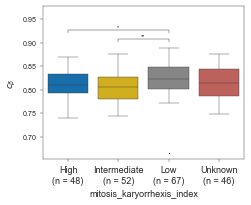

In [178]:
pc_util.saveBoxPlotNew(clinical['TARGET'], 'mitosis_karyorrhexis_index', restrict=False,
                   var_y='c_beta', outfile=False, title=False, signif_bar_heights = 0.02,
                   palette=pc_consts['palette_jco'], xlabel='mitosis_karyorrhexis_index',
                   figsize=np.array([9, 7]), labelfontsize=pc_consts['labelfontsize'] * 0.9, ticksfontsize=pc_consts['ticksfontsize'], sf=sf, linewidth=pc_consts['linewidth'], fliersize=pc_consts['fliersize'])

<Axes: xlabel='inpc_grade', ylabel='$c_β$'>

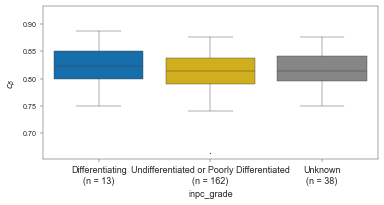

In [177]:
pc_util.saveBoxPlotNew(clinical['TARGET'], 'inpc_grade', restrict=False,
                   var_y='c_beta', outfile=False, title=False, signif_bar_heights = 0.02,
                   palette=pc_consts['palette_jco'], xlabel='inpc_grade',
                   figsize=np.array([15, 7]), labelfontsize=pc_consts['labelfontsize'] * 0.9, ticksfontsize=pc_consts['ticksfontsize'], sf=sf, linewidth=pc_consts['linewidth'], fliersize=pc_consts['fliersize'])

<Axes: xlabel='icd_10_code', ylabel='$c_β$'>

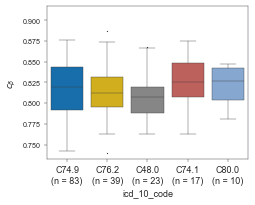

In [176]:
pc_util.saveBoxPlotNew(clinical['TARGET'], 'icd_10_code', restrict=False,
                   var_y='c_beta', outfile=False, title=False, signif_bar_heights = 0.02,
                   palette=pc_consts['palette_jco'], xlabel='icd_10_code',
                       use_groups=clinical['TARGET']['icd_10_code'].value_counts().sort_values(ascending=False).index[:5].values,
                   figsize=np.array([9, 7]), labelfontsize=pc_consts['labelfontsize'] * 0.9, ticksfontsize=pc_consts['ticksfontsize'], sf=sf, linewidth=pc_consts['linewidth'], fliersize=pc_consts['fliersize'])

/Users/danielmonyak/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: title={'center': 'c_beta by Race'}, xlabel='race_3cat', ylabel='$c_β$'>

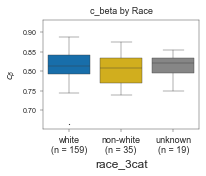

In [175]:
def map_race_to_3cat(race_value):
    """
    Convert each race entry into 'white', 'nonwhite', or 'unknown'.
    """
    if pd.isna(race_value) or str(race_value).lower() == 'unknown':
        return 'unknown'
    elif str(race_value).lower() == 'white':
        return 'white'
    else:
        return 'non-white'

# Apply this mapping to your 'race' column
clinical['TARGET']['race_3cat'] = clinical['TARGET']['race'].apply(map_race_to_3cat)

# Option A: Make it a categorical with the correct order
cat_order = ['white', 'non-white', 'unknown']
clinical['TARGET']['race_3cat'] = pd.Categorical(
    clinical['TARGET']['race_3cat'],
    categories=cat_order,
    ordered=True
)

pc_util.saveBoxPlotNew(
    sample_annotations = clinical['TARGET'],
    var_cat           = 'race_3cat',
    var_y             = 'c_beta',
    restrict          = False,
    use_groups        = cat_order,
    outdir            = '.',
    outfile           = False,
    title             = False,
    custom_title      = 'c_beta by Race',
    palette           = pc_consts['palette_jco'],
    xlabel            = 'Race',
    figsize           = np.array([7, 5]),
    labelfontsize     = pc_consts['labelfontsize'] * 0.9,
    ticksfontsize     = pc_consts['ticksfontsize'],
    sf                = sf,
    linewidth         = pc_consts['linewidth'],
    fliersize         = pc_consts['fliersize']
)


<Axes: xlabel='gender', ylabel='$c_β$'>

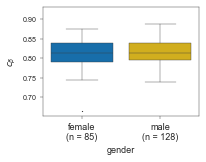

In [174]:
pc_util.saveBoxPlotNew(clinical['TARGET'], 'gender', restrict=False,
                   var_y='c_beta', outfile=False, title=False, signif_bar_heights = 0.02,
                   palette=pc_consts['palette_jco'], xlabel='gender',
                   figsize=np.array([7, 5]), labelfontsize=pc_consts['labelfontsize'] * 0.9, ticksfontsize=pc_consts['ticksfontsize'], sf=sf, linewidth=pc_consts['linewidth'], fliersize=pc_consts['fliersize'])

In [82]:
pc_util.getCorrelation(clinical['TARGET'], 'Age', 'c_beta')

LinregressResult(slope=np.float64(-13.421923660083113), intercept=np.float64(13.536316269510161), rvalue=np.float64(-0.22815244015844602), pvalue=np.float64(0.004839217292704344), stderr=np.float64(4.692328597505232), intercept_stderr=np.float64(3.5776745550983886))

In [83]:
print(pc_util.getCorrelation(clinical['TARGET'], 'Age', 'c_beta'))
print(pc_util.getCorrelation(clinical['TARGET'], 'Age', 'c_beta', use_samples=clinical['TARGET'].index[clinical['TARGET']['Age'] < 7.5]))

LinregressResult(slope=np.float64(-13.421923660083113), intercept=np.float64(13.536316269510161), rvalue=np.float64(-0.22815244015844602), pvalue=np.float64(0.004839217292704344), stderr=np.float64(4.692328597505232), intercept_stderr=np.float64(3.5776745550983886))
LinregressResult(slope=np.float64(-8.07137870393231), intercept=np.float64(8.971147598717957), rvalue=np.float64(-0.21282017040743265), pvalue=np.float64(0.010712890444934252), stderr=np.float64(3.120761401895775), intercept_stderr=np.float64(2.3838545711259))


In [87]:
clinical['TARGET'].loc[clinical['TARGET']['vital_status'] == 'Dead'].iloc[0]

project                                                                     TARGET-NBL
disease_type                                            Neuroepitheliomatous Neoplasms
primary_site                                                             Adrenal gland
submitter_id.1                                                        TARGET-30-PARNEE
inss_stage                                                                     Stage 4
days_to_diagnosis                                                                  0.0
created_datetime                                      2016-04-25T16:44:22.906788-05:00
treatments                           ANBL00B1, 2024-03-13T17:13:56.180548-05:00, 72...
last_known_disease_status                                                          NaN
tissue_or_organ_of_origin                                           Adrenal gland, NOS
days_to_last_follow_up                                                             NaN
age_at_diagnosis                           

# Beta values

In [88]:
beta_values_Clock = pd.read_table(os.path.join(proj_dir, 'NBL.methyl.traditional_sites.tsv'), index_col=0)

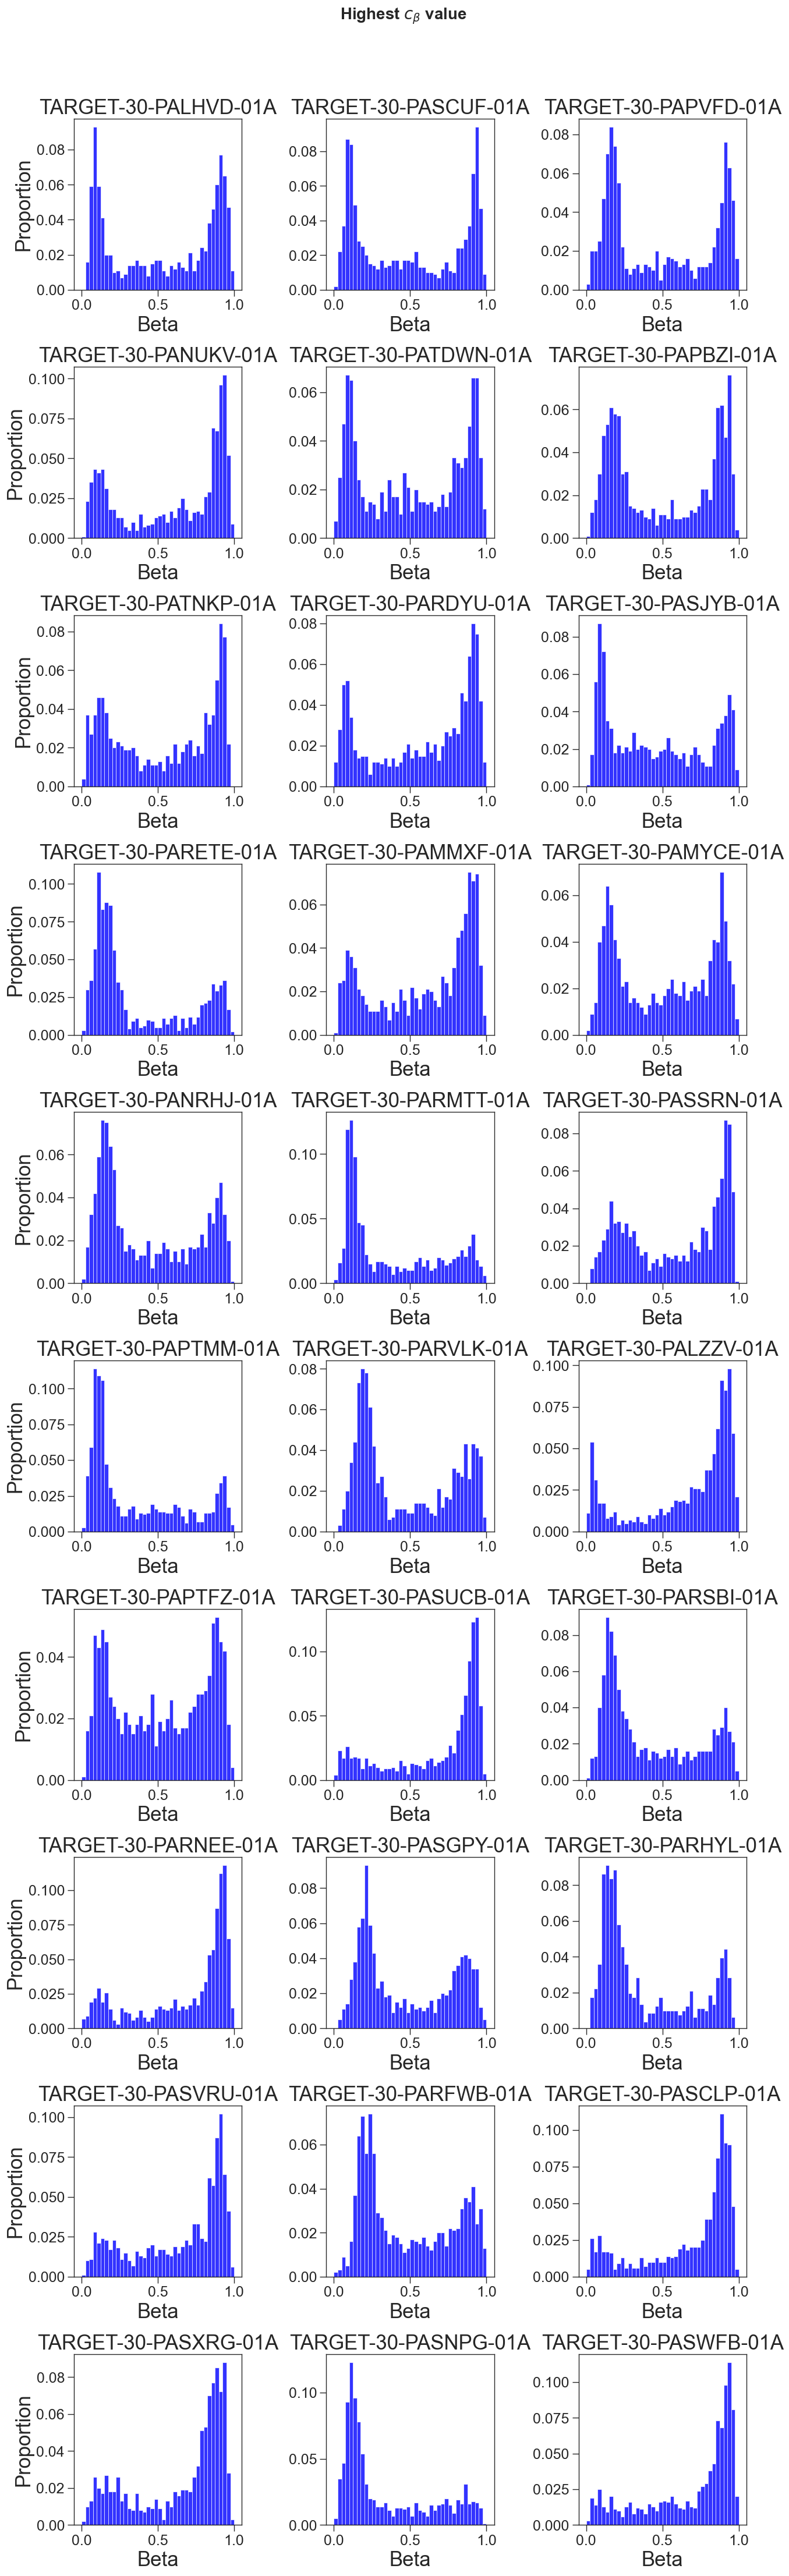

In [89]:
n_samps = 30

# Plot Clock beta values youngest tumors and save plot
youngest = c_beta.sort_values().index[:n_samps]
pc_util.plotTumorWise(
    beta_values_Clock,
    data_obj = "beta_decomp",
    n_samps=n_samps, ncols=3,
    choose_random=False,
    sample_list=youngest,
    figsize=figsize * [2, 4.5/18 * n_samps], text_fontsize=pc_consts['labelfontsize'], ticksfontsize=pc_consts['ticksfontsize'], opacity=pc_consts['opacity'], sf=1,
    tight_layout_pad=6, bins=40,
    suptitle='Highest $c_β$ value',
    outfile=True, outfile_name='NBL-youngest_tumors.pdf', outdir=figure_outdir
)

In [90]:
clinical['TARGET'].groupby('vital_status')['cog_neuroblastoma_risk_group'].value_counts().unstack()

cog_neuroblastoma_risk_group,High Risk,Intermediate Risk,Low Risk
vital_status,,,
Alive,46.0,9.0,22.0
Dead,73.0,1.0,NaN


In [91]:
clinical['TARGET']['Age']

submitter_id
TARGET-30-PASUCB    2.761644
TARGET-30-PASNPG    0.871233
TARGET-30-PARNEE    2.934247
TARGET-30-PALXTB    1.739726
TARGET-30-PAMMXF    4.550685
                      ...   
TARGET-30-PALVVH    0.600000
TARGET-30-PATYIL    0.898630
TARGET-30-PAPBGH    2.942466
TARGET-30-PAREGK    1.556164
TARGET-30-PAMZSH    0.863014
Name: Age, Length: 151, dtype: float64

In [92]:
clinical['TARGET']['Clock estimate'] = -np.log(1 - 2*clinical['TARGET']['c_beta']) / 2

/Users/grahamgumbert/myenv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [93]:
clinical['TARGET']['c_beta']

submitter_id
TARGET-30-PASUCB    0.700583
TARGET-30-PASNPG    0.709532
TARGET-30-PARNEE    0.701682
TARGET-30-PALXTB    0.807062
TARGET-30-PAMMXF    0.688997
                      ...   
TARGET-30-PALVVH    0.804176
TARGET-30-PATYIL    0.735402
TARGET-30-PAPBGH    0.735418
TARGET-30-PAREGK    0.788461
TARGET-30-PAMZSH    0.836455
Name: c_beta, Length: 151, dtype: float64

In [94]:
clinical['TARGET']['Clock estimate']

submitter_id
TARGET-30-PASUCB   NaN
TARGET-30-PASNPG   NaN
TARGET-30-PARNEE   NaN
TARGET-30-PALXTB   NaN
TARGET-30-PAMMXF   NaN
                    ..
TARGET-30-PALVVH   NaN
TARGET-30-PATYIL   NaN
TARGET-30-PAPBGH   NaN
TARGET-30-PAREGK   NaN
TARGET-30-PAMZSH   NaN
Name: Clock estimate, Length: 151, dtype: float64

(array([39., 50., 34., 17.,  4.,  2.,  0.,  2.,  1.,  2.]),
 array([-0.81039807,  0.85106956,  2.51253719,  4.17400482,  5.83547244,
         7.49694007,  9.1584077 , 10.81987533, 12.48134296, 14.14281058,
        15.80427821]),
 <BarContainer object of 10 artists>)

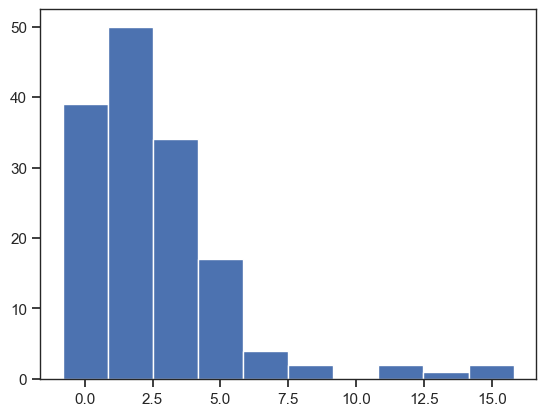

In [95]:
plt.hist(clinical['TARGET']['Age'] - clinical['TARGET']['c_beta'])

<Axes: xlabel='c_beta', ylabel='Age'>

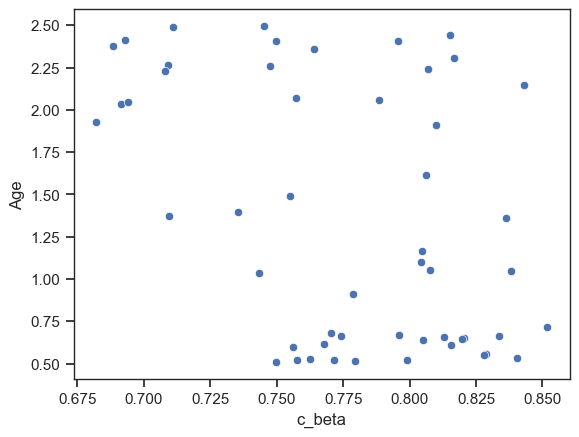

In [96]:
mask = clinical['TARGET']['Age'] < 2
sns.scatterplot(x=clinical['TARGET'].loc[mask, 'c_beta'], y=clinical['TARGET'].loc[mask, 'Age']+0.5)

## Waterfall plot

In [278]:
clinical['TARGET'] = pd.read_csv('/Users/danielmonyak/Library/CloudStorage/Box-Box/PROJECT 06023: MolClocks/Neuroblastoma_Paper/0. PAPER/2. Figures/forDan.csv', index_col=0)
clinical['TARGET']['Stage 4'] = (clinical['TARGET']['inss_stage'] == 'Stage 4').map(lambda x:'Stage 4' if x else 'Stage 1, 3, or 4S')

color_var = 'Stage 4'
color_dict = dict(zip(clinical['TARGET'][color_var].unique(), [pc_consts['palette_jco'][3], pc_consts['palette_jco'][4]]))

def swimmersPlot(tumors_chosen, figsize, filename, legend=True):
    fig, ax = plt.subplots(figsize=np.array(figsize) * sf)
    tumors_ordered = clinical['TARGET'].loc[tumors_chosen].sort_values('Age').index

    for i, tum in enumerate(tumors_ordered):
        x_points = [clinical['TARGET'].loc[tum, 'Age'] - clinical['TARGET'].loc[tum, 'calendar_age'] / 365, clinical['TARGET'].loc[tum, 'Age']]
        y_points = [i, i]
        color = color_dict[clinical['TARGET'].loc[tum, color_var]]

        # Plot the circle on the left side
        ax.plot(x_points[0], y_points[0], 'o', markersize=4*sf, color=color)  # green circle

        # Draw the line with an arrowhead at the right side
        ax.annotate(
            '', 
            xy=(x_points[1], y_points[1]),
            xytext=(x_points[0]-0.05, y_points[0]),
            arrowprops=dict(arrowstyle='-|>', color=color,
                            linewidth=2*sf, mutation_scale=12*sf)
        )


    patches = [mpatches.Patch(color=color_dict[group], label=group) for group in color_dict.keys()]
    plots_x, plots_y = ax.get_position().get_points()[1]

    if legend:
        fig.legend(handles=patches,
                   loc='upper right',
                   bbox_to_anchor=(plots_x, plots_y * 0.22),
                   fontsize= 1.2 * pc_consts['labelfontsize'] * sf
                  )

    ax.set_xlabel('Patient age (years)', fontsize= 1.6 * pc_consts['labelfontsize']*sf)
    ax.tick_params(axis='y', which='both', left=False, labelleft=False)  
    ax.tick_params(axis='x', labelsize= 1.2 * pc_consts['ticksfontsize'] * sf, width=sf, length=8 * sf)

    ax.axvline(x=0, color=pc_consts['palette_jco'][2], linestyle='--', linewidth=3*sf)
    ax.axvline(x=-0.75, color=pc_consts['palette_jco'][2], linestyle='--', linewidth=3*sf)


    ax.set_xlim(left=-1.5, right=clinical['TARGET'].loc[tumors_chosen, 'Age'].max())

    bottom = -4
    top = len(tumors_ordered) + 4
    ax.set_ylim(bottom, top)
    ax.fill([0, 1, 1, 0], [bottom, bottom, top, top],
            color=pc_consts['palette_jco'][2], alpha=0.2, lw=0)

    # Save figure
    fig.savefig(os.path.join(figure_outdir, filename), format='pdf', pad_inches=0.1)

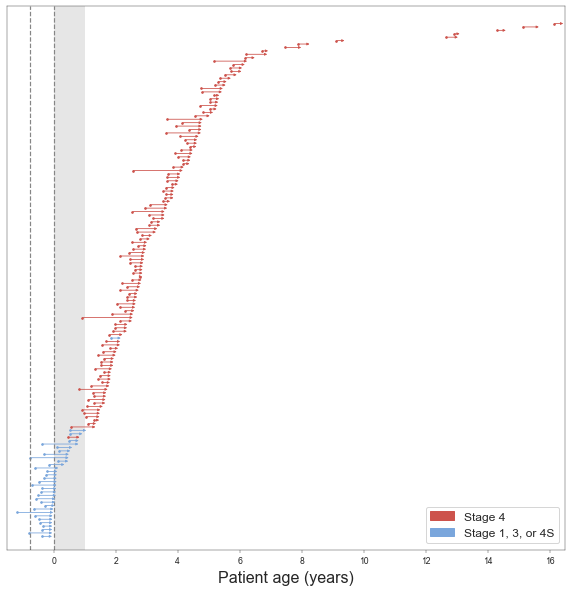

In [279]:
all_patients = clinical['TARGET'].index[clinical['TARGET']['in_analysis_dataset']]
swimmersPlot(all_patients, (25, 25), 'swimmer_plot_all.pdf')

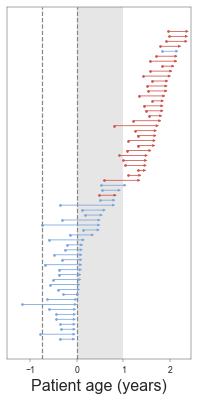

In [280]:
young_patients = clinical['TARGET'].index[clinical['TARGET']['in_analysis_dataset'] & (clinical['TARGET']['Age'] <= 2.5)]

figsize_young = np.array([
    25 * (clinical['TARGET'].loc[young_patients, 'Age'].max() - (-1.5)) / (clinical['TARGET'].loc[all_patients, 'Age'].max() - (-1.5)),
    25 * (young_patients.shape[0] - (-4)) / (all_patients.shape[0] - (-4))
])
    
swimmersPlot(young_patients, figsize_young * 1.5, 'swimmer_plot_young.pdf', legend=False)